In [1]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import pandas as pd
import matplotlib.pyplot as plt
from dataset import *
from evaluation import *
from train import *
from models import *
from sklearn.metrics import classification_report
from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings('ignore')

## I. Data inspection: check distribution

<AxesSubplot:>

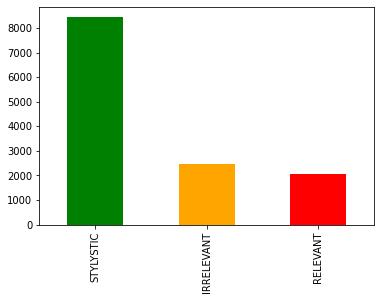

In [8]:
datapath = '../generated_data/similar_sentences_large.xlsx'
df = pd.read_excel(datapath)
#plot the distribution of the labels with different colors
df['label'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])

In [3]:
df['label'].value_counts()

STYLYSTIC     8430
IRRELEVANT    2469
RELEVANT      2069
Name: label, dtype: int64

## II. bert tokenizer demo

In [ ]:
from transformers import BertTokenizer
from transformers import RobertaTokenizer
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text, example_text ,padding='max_length', max_length = 20, 
                       truncation=True, return_tensors="pt")

In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])
example_text

## III. Data set

In [9]:
train_dataloader, val_dataloader, test_dataloader = get_dataloader(df, tokenizer='bert-base-cased')

IRRELEVANT    1668
RELEVANT      1668
STYLYSTIC     1668
Name: label, dtype: int64
train: 5004 val: 1297 test: 1297


## IV. Models

In [11]:
# Load the model
#pretrain = 'nlpaueb/legal-bert-base-uncased'
#pretrain = 'bert-base-uncased'
#model = BertClassifier(pretrain = pretrain)
model = RobertaClassifier()

## V. Training

In [5]:
EPOCHS = 3
LR = 1e-6
              
train(model, train_dataloader, val_dataloader, LR, EPOCHS)

# Save the model
#model_name = 'roberta-base_{}.pt'.format(EPOCHS)
#model_name = 'legal-bert-base_{}.pt'.format(EPOCHS)
model_name = 'bert-base_{}.pt'.format(EPOCHS)
torch.save(model.state_dict(), 'models/' + model_name)

100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.055                 | Train Accuracy:  0.640                 | Val Loss:  0.039                 | Val Accuracy:  0.843


100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.036                 | Train Accuracy:  0.855                 | Val Loss:  0.028                 | Val Accuracy:  0.906


100%|██████████| 313/313 [01:49<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.023                 | Train Accuracy:  0.931                 | Val Loss:  0.019                 | Val Accuracy:  0.931


## VI. Evaluation

In [6]:
# Load the model
model = BertClassifier(pretrain = pretrain)
#model = RobertaClassifier()
model.load_state_dict(torch.load('models/' + model_name))
evaluate(model, test_dataloader)

Test Accuracy:  0.938
Test F1:  0.886
Test Precision:  0.885
Test Recall:  0.911


In [8]:
train(model, train_dataloader, val_dataloader, LR, 6)

100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 1 | Train Loss:  0.003                 | Train Accuracy:  0.991                 | Val Loss:  0.004                 | Val Accuracy:  0.981


100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 2 | Train Loss:  0.002                 | Train Accuracy:  0.994                 | Val Loss:  0.006                 | Val Accuracy:  0.975


100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.002                 | Train Accuracy:  0.995                 | Val Loss:  0.004                 | Val Accuracy:  0.978


100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.001                 | Train Accuracy:  0.997                 | Val Loss:  0.004                 | Val Accuracy:  0.979


100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.001                 | Train Accuracy:  0.996                 | Val Loss:  0.003                 | Val Accuracy:  0.981


100%|██████████| 313/313 [01:47<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.001                 | Train Accuracy:  0.998                 | Val Loss:  0.004                 | Val Accuracy:  0.980


In [39]:
evaluate(model, test_dataloader)

Test Accuracy:  0.941
Test F1:  0.892
Test Precision:  0.890
Test Recall:  0.921


In [ ]:
torch.save(model.state_dict(), 'models/' + 'legal_bert_{}.pt'.format(10))

In [10]:
model_name = 'roberta-base_{}.pt'.format(10)
torch.save(model.state_dict(), 'models/' + model_name)

In [6]:
model = BertClassifier('bert-base-uncased')
model.load_state_dict(torch.load('models/' + 'bert-base_3.pt'))

<All keys matched successfully>

In [8]:

def show_classification_report(model):
    #get all the predictions on the test set
    y_pred = []
    y_true = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        model = model.to(device)
        for test_input, test_label in tqdm(test_dataloader):

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            y_pred.extend(output.argmax(dim=1).cpu().tolist())
            y_true.extend(test_label.cpu().tolist())

    #print the classification report
    print(classification_report(y_true, y_pred, digits=3))

In [33]:
show_classification_report(model)

100%|██████████| 82/82 [00:09<00:00,  8.26it/s]

              precision    recall  f1-score   support

           0      0.759     0.928     0.835       194
           1      0.994     0.935     0.963       859
           2      0.921     0.951     0.935       244

    accuracy                          0.937      1297
   macro avg      0.891     0.938     0.911      1297
weighted avg      0.945     0.937     0.939      1297



In [34]:
model_legal = BertClassifier('nlpaueb/legal-bert-base-uncased')
model_legal.load_state_dict(torch.load('models/legal-bert-base_3.pt'))
show_classification_report(model_legal)

100%|██████████| 82/82 [00:09<00:00,  8.45it/s]

              precision    recall  f1-score   support

           0      0.699     0.933     0.799       194
           1      0.994     0.907     0.948       859
           2      0.933     0.971     0.952       244

    accuracy                          0.923      1297
   macro avg      0.875     0.937     0.900      1297
weighted avg      0.938     0.923     0.927      1297



In [7]:
evaluate(roberta_model, test_dataloader)

Test Accuracy:  0.960
Test F1:  0.939
Test Precision:  0.940
Test Recall:  0.956


In [9]:
show_classification_report(roberta_model)

100%|██████████| 82/82 [00:09<00:00,  8.41it/s]

              precision    recall  f1-score   support

           0      0.791     0.974     0.873       194
           1      0.996     0.956     0.976       859
           2      0.983     0.943     0.962       244

    accuracy                          0.956      1297
   macro avg      0.923     0.958     0.937      1297
weighted avg      0.963     0.956     0.958      1297

